# Classifying prompt vs. fake photons from $t\bar{t}$, $t\bar{t}+\gamma$ events

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from coffea import hist, util
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import uproot

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [2]:
class PhotonSelector(processor.ProcessorABC):
    def __init__(self, isMC=True):
        
        # data is/isn't Monte Carlo
        self.isMC = isMC

        # declare axes
        dataset_axis = hist.Cat("dataset","Dataset")
        #data_dataset_axis = hist.Cat("dataset",None)

        photon_pt_axis = hist.Bin("pt","$p_{T}$ [GeV]", 40, 0, 200)
        photon_eta_axis = hist.Bin("eta","$\eta$", 50, -2, 2)
        photon_phi_axis = hist.Bin("phi","$\phi$", 64, -3.2, 3.2)
        photon_reliso_all_axis = hist.Bin("reliso","pfRelIso03_all", 40, 0, 0.2)
        photon_reliso_chg_axis = hist.Bin("reliso","pfRelIso03_chg", 40, 0, 0.2)
        photon_sieie_axis = hist.Bin("sieie","$\sigma_{i\eta i\eta}$", 40, 0, 0.03)
        photon_r9_axis = hist.Bin("r9","R9", 40, 0.2, 1.1)
        photon_hoe_axis = hist.Bin("hoe","H over E", 40, 0, 0.1)
        
        mu_deltar_axis = hist.Bin("deltar","$\Delta R$: photon-muon", 50, 0, 4)
        jet_deltar_axis = hist.Bin("deltar","$\Delta R$: photon-jet", 50, 0, 4)
        
        mvaid_axis = hist.Bin("mvaid", "mvaID", 25,-1,1)

        flavLabel_axis = hist.Bin("flav",None,[0,1,13,14])
        photon_genPartFlav_axis = hist.Bin("flav","genPartFlav",14,0,14)
        
        
        # accumulator object: dictionary storing histograms & counters to be filled
        if self.isMC:
            self._accumulator = processor.dict_accumulator({

                ## column accumulators
                'photon_pt': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_eta': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_phi': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_pfRelIso03_all': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_pfRelIso03_chg': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_sieie': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_r9': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_hoe': processor.column_accumulator(np.ndarray(shape=(0,))),
                'deltaR_photon_lepton': processor.column_accumulator(np.ndarray(shape=(0,))),
                'deltaR_photon_jet': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_mvaid': processor.column_accumulator(np.ndarray(shape=(0,))),
                'file': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_genPartFlav': processor.column_accumulator(np.ndarray(shape=(0,))),

                ## histograms for features
                'photon_pt_hist': hist.Hist("Counts", dataset_axis, photon_pt_axis, flavLabel_axis),
                'photon_eta_hist': hist.Hist("Counts", dataset_axis, photon_eta_axis, flavLabel_axis),
                'photon_phi_hist': hist.Hist("Counts", dataset_axis, photon_phi_axis, flavLabel_axis),
                'photon_reliso_all_hist': hist.Hist("Counts", dataset_axis, photon_reliso_all_axis, flavLabel_axis),
                'photon_reliso_chg_hist': hist.Hist("Counts", dataset_axis, photon_reliso_chg_axis, flavLabel_axis),
                'photon_sieie_hist': hist.Hist("Counts", dataset_axis, photon_sieie_axis, flavLabel_axis),
                'photon_r9_hist': hist.Hist("Counts", dataset_axis, photon_r9_axis, flavLabel_axis),
                'photon_hoe_hist': hist.Hist("Counts", dataset_axis, photon_hoe_axis, flavLabel_axis),
                'deltaR_photon_lepton_hist': hist.Hist("Counts", dataset_axis, mu_deltar_axis, flavLabel_axis),
                'deltaR_photon_jet_hist': hist.Hist("Counts", dataset_axis, jet_deltar_axis, flavLabel_axis),
                'photon_mvaid_hist': hist.Hist("Counts", dataset_axis, mvaid_axis, flavLabel_axis),
                'photon_genPartFlav_hist': hist.Hist("Counts", dataset_axis, photon_genPartFlav_axis),
            }
            )
        if self.isMC==0:
            self._accumulator = processor.dict_accumulator({
                
                ## column accumulators
                'photon_pt': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_eta': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_phi': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_pfRelIso03_all': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_pfRelIso03_chg': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_sieie': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_r9': processor.column_accumulator(np.ndarray(shape=(0,))),
                'photon_hoe': processor.column_accumulator(np.ndarray(shape=(0,))),
                'deltaR_photon_lepton': processor.column_accumulator(np.ndarray(shape=(0,))),
                'deltaR_photon_jet': processor.column_accumulator(np.ndarray(shape=(0,))),
                
                ## histograms for features
                'photon_pt_hist': hist.Hist("Counts", dataset_axis, photon_pt_axis),
                'photon_eta_hist': hist.Hist("Counts", dataset_axis, photon_eta_axis),
                'photon_phi_hist': hist.Hist("Counts", dataset_axis, photon_phi_axis),
                'photon_reliso_all_hist': hist.Hist("Counts", dataset_axis, photon_reliso_all_axis),
                'photon_reliso_chg_hist': hist.Hist("Counts", dataset_axis, photon_reliso_chg_axis),
                'photon_sieie_hist': hist.Hist("Counts", dataset_axis, photon_sieie_axis),
                'photon_r9_hist': hist.Hist("Counts", dataset_axis, photon_r9_axis),
                'photon_hoe_hist': hist.Hist("Counts", dataset_axis, photon_hoe_axis),
                'deltaR_photon_lepton_hist': hist.Hist("Counts", dataset_axis, mu_deltar_axis),
                'deltaR_photon_jet_hist': hist.Hist("Counts", dataset_axis, jet_deltar_axis),
            }
            )

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        
        output = self.accumulator.identity()
        dataset = events.metadata['dataset']
        
        ######## object & event selection ########
        # muons
        muons=events.Muon
        muonSelectTight = ((muons.pt>30) &
                           (abs(muons.eta)<2.4) &
                           (muons.tightId) &
                           (muons.pfRelIso04_all < 0.15)
                          )
        tightMuons = muons[muonSelectTight]
        
        # jets & b-tagged jets
        jets=events.Jet
        jetSelectTight = ((jets.pt>30) &
                          (abs(jets.eta)<2.4) &
                          (jets.isTight)
                         )
        btaggedJetSelect = (jetSelectTight &
                           (jets.btagDeepB>0.6321)
                          )
        tightJets = jets[jetSelectTight]
        tightBJets = jets[btaggedJetSelect]
        
        # electrons
        electrons=events.Electron
        electronSelectTight = ((electrons.pt> 35) &
                               (abs(electrons.eta)<2.1) &
                               electrons.cutBased>=4 # tight cut-based ID
                              )
        tightEle = electrons[electronSelectTight]
        
        
        # delta R cuts
        phoMu, phoMuDR = events.Photon.nearest(tightMuons,return_metric=True)
        phoMuMask = ak.fill_none(phoMuDR>0.4,True)
        
        phoJet, phoJetDR = events.Photon.nearest(tightJets,return_metric=True)
        phoJetMask = ak.fill_none(phoJetDR>0.4,True)
        
        
        # photons
        photons = events.Photon
        photonSelect= ((photons.pt>20) &
                       (abs(photons.eta) < 1.4442) &
                       (photons.isScEtaEE | photons.isScEtaEB) &
                       (photons.electronVeto) & 
                       np.invert(photons.pixelSeed) &
                       phoMuMask & phoJetMask
                       )
        tightPhotons = photons[photonSelect]
        
        tightPhoMu, tightPhoMuDR = tightPhotons.nearest(tightMuons,return_metric=True)
        tightPhoJet, tightPhoJetDR = tightPhotons.nearest(tightJets,return_metric=True)
        
        
        # events
        trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24
        
        eventSelection = (trigger &
                          (ak.num(tightMuons)==1) &
                          (ak.num(tightJets)>=4) & 
                          (ak.num(tightBJets)>=1) &
                          (ak.num(tightEle)==0) &
                          (ak.num(tightPhotons)>=1))

        
        ######## fill histograms: Monte Carlo ########
        if self.isMC:
            flavLabel = ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav))
            flavLabel[flavLabel == 13] = 0 # relabel prompt electrons as fake photons
            
            output['photon_pt_hist'].fill(dataset=dataset, flav=flavLabel,
                                          pt=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pt)))
            output['photon_eta_hist'].fill(dataset=dataset, flav=flavLabel,
                                           eta=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].eta)))
            output['photon_phi_hist'].fill(dataset=dataset, flav=flavLabel,
                                           phi=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].phi)))
            output['photon_reliso_all_hist'].fill(dataset=dataset, flav=flavLabel,
                                                  reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_all)))
            output['photon_reliso_chg_hist'].fill(dataset=dataset, flav=flavLabel,
                                                  reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg)))
            output['photon_sieie_hist'].fill(dataset=dataset, flav=flavLabel,
                                             sieie=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].sieie)))
            output['photon_r9_hist'].fill(dataset=dataset, flav=flavLabel,
                                          r9=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].r9)))
            output['photon_hoe_hist'].fill(dataset=dataset, flav=flavLabel,
                                           hoe=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].hoe)))
            
            output['deltaR_photon_lepton_hist'].fill(dataset=dataset, flav=flavLabel,
                                                     deltar=ak.to_numpy(ak.flatten(tightPhoMuDR[eventSelection])))
            output['deltaR_photon_jet_hist'].fill(dataset=dataset, flav=flavLabel,
                                                  deltar=ak.to_numpy(ak.flatten(tightPhoJetDR[eventSelection])))
            
            output['photon_mvaid_hist'].fill(dataset=dataset, flav=flavLabel,
                                             mvaid=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].mvaID)))
        
            output['photon_genPartFlav_hist'].fill(dataset=dataset,
                                                   flav=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].genPartFlav)))
        
        ######## fill histograms: Data ########
        if self.isMC==0:
            output['photon_pt_hist'].fill(dataset=dataset,
                                          pt=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pt)))
            output['photon_eta_hist'].fill(dataset=dataset,
                                           eta=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].eta)))
            output['photon_phi_hist'].fill(dataset=dataset,
                                           phi=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].phi)))
            output['photon_reliso_all_hist'].fill(dataset=dataset,
                                                  reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_all)))
            output['photon_reliso_chg_hist'].fill(dataset=dataset,
                                                  reliso=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].pfRelIso03_chg)))
            output['photon_sieie_hist'].fill(dataset=dataset,
                                             sieie=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].sieie)))
            output['photon_r9_hist'].fill(dataset=dataset,
                                          r9=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].r9)))
            output['photon_hoe_hist'].fill(dataset=dataset,
                                           hoe=ak.to_numpy(ak.flatten(tightPhotons[eventSelection].hoe)))
            
            output['deltaR_photon_lepton_hist'].fill(dataset=dataset,
                                                     deltar=ak.to_numpy(ak.flatten(tightPhoMuDR[eventSelection])))
            output['deltaR_photon_jet_hist'].fill(dataset=dataset,
                                                  deltar=ak.to_numpy(ak.flatten(tightPhoJetDR[eventSelection])))
            
        
        ######## fill column accumulators ########
        output['photon_pt'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pt[eventSelection])))
        output['photon_eta'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.eta[eventSelection])))
        output['photon_phi'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.phi[eventSelection])))
        output['photon_pfRelIso03_all'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_all[eventSelection])))
        output['photon_pfRelIso03_chg'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.pfRelIso03_chg[eventSelection])))
        output['photon_sieie'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.sieie[eventSelection])))
        output['photon_r9'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.r9[eventSelection])))
        output['photon_hoe'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.hoe[eventSelection])))
        
        output['deltaR_photon_lepton'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhoMuDR[eventSelection])))
        output['deltaR_photon_jet'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhoJetDR[eventSelection])))
        
        output['photon_mvaid'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.mvaID[eventSelection])))
        
        if self.isMC:
            output['photon_genPartFlav'] = processor.column_accumulator(ak.to_numpy(ak.flatten(tightPhotons.genPartFlav[eventSelection])))
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [3]:
# Define files to run over
skimDir="/udrive/staff/dnoonan/Skims"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"],
          }
filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"],
              }

In [4]:
np.warnings.filterwarnings('ignore')

# The NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

# Run Coffea code using uproot
outputMC = processor.run_uproot_job(
    fileset,
    "Events",
    PhotonSelector(),
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},
    chunksize=1000000,
    #maxchunks=3,
)

Preprocessing:   0%|          | 0/3 [00:00<?, ?file/s]

Processing:   0%|          | 0/10 [00:00<?, ?chunk/s]

In [5]:
outputData = processor.run_uproot_job(
    filesetData,
    "Events",
    PhotonSelector(isMC=False),
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},
    chunksize=1000000,
    #maxchunks=3,
)

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/6 [00:00<?, ?chunk/s]

## Luminosity scaling

In [6]:
# get number of events in each dataset
nEvents = {}
for d in fileset:
    if not d in nEvents:
        nEvents[d] = 0
    for fName in fileset[d]:
        with uproot.open(fName)['hEvents'] as hEvents:
            nEvents[d] += hEvents.values()[0] + hEvents.values()[2]

print(nEvents)

{'TTGamma': 11005200.0, 'TTbar': 17673700.0}


In [7]:
# cross-section
cx = {'TTGamma':7.509,
      'TTbar': 380.095,}

# weights
lumi_weight = {}
for keyName in fileset:
    lumi_weight[keyName] = (cx[keyName]*578.)/nEvents[keyName]

print(lumi_weight)

{'TTGamma': 0.00039437738523607027, 'TTbar': 0.012430612152520412}


In [8]:
for key, obj in outputMC.items():
    if isinstance(obj, hist.Hist):
        obj.scale(lumi_weight, axis="dataset")

## Plot Features

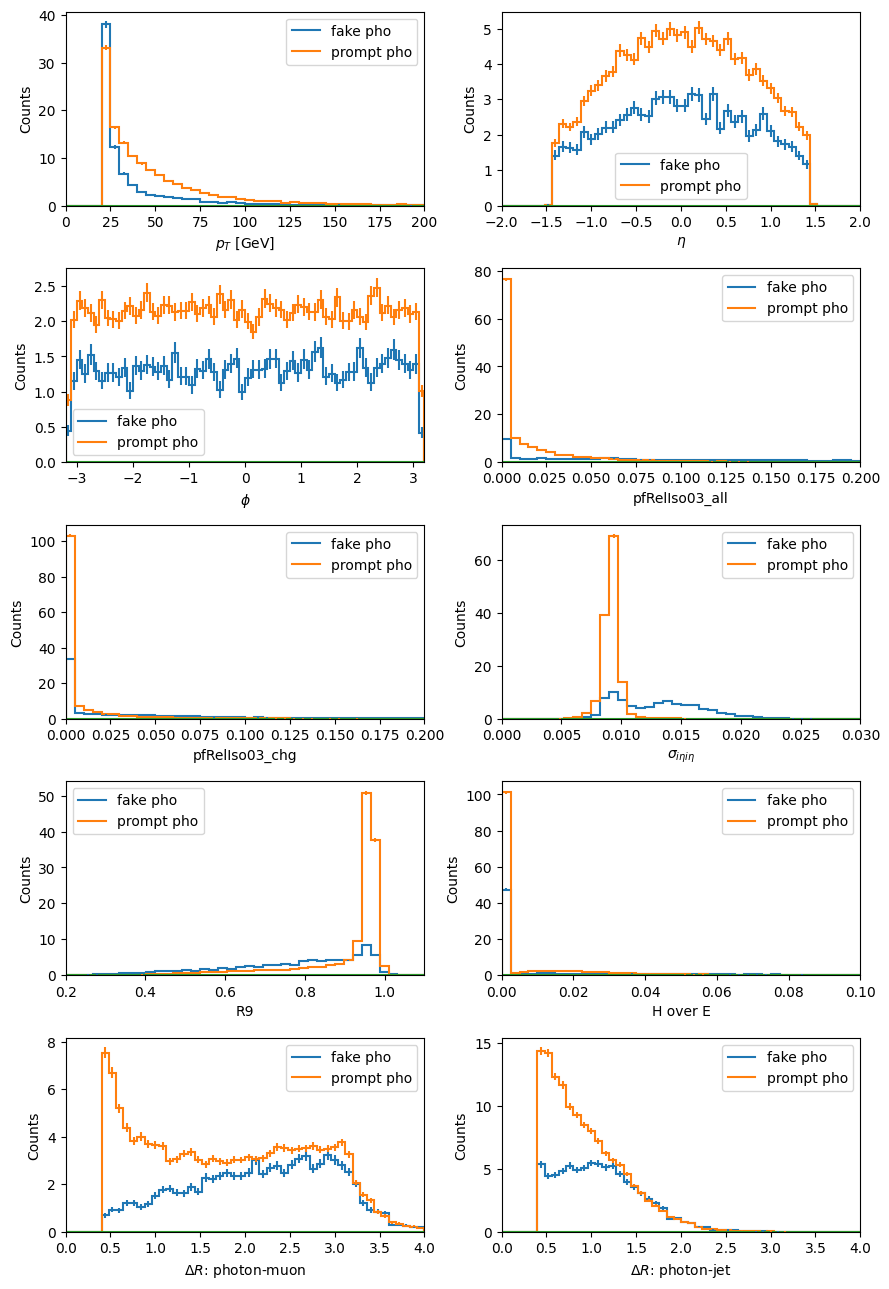

In [9]:
fig, axs = plt.subplots(5,2,figsize=(9,13),dpi=100)

legopts = {'labels': ['fake pho','prompt pho']}

hist.plot1d(outputMC['photon_pt_hist'].sum("dataset"),overlay="flav",stack=False,ax=axs[0,0],legend_opts=legopts)
hist.plot1d(outputMC['photon_eta_hist'].sum("dataset"),overlay="flav",stack=False,ax=axs[0,1],legend_opts=legopts)
hist.plot1d(outputMC['photon_phi_hist'].sum("dataset"),overlay="flav",stack=False,ax=axs[1,0],legend_opts=legopts)
hist.plot1d(outputMC['photon_reliso_all_hist'].sum("dataset"),overlay="flav",stack=False,ax=axs[1,1],legend_opts=legopts)
hist.plot1d(outputMC['photon_reliso_chg_hist'].sum("dataset"),overlay="flav",stack=False,ax=axs[2,0],legend_opts=legopts)
hist.plot1d(outputMC['photon_sieie_hist'].sum("dataset"),overlay="flav",stack=False,ax=axs[2,1],legend_opts=legopts)
hist.plot1d(outputMC['photon_r9_hist'].sum("dataset"),overlay="flav",stack=False,ax=axs[3,0],legend_opts=legopts)
hist.plot1d(outputMC['photon_hoe_hist'].sum("dataset"),overlay="flav",stack=False,ax=axs[3,1],legend_opts=legopts)
hist.plot1d(outputMC['deltaR_photon_lepton_hist'].sum("dataset"),overlay="flav",stack=False,ax=axs[4,0],legend_opts=legopts)
hist.plot1d(outputMC['deltaR_photon_jet_hist'].sum("dataset"),overlay="flav",stack=False,ax=axs[4,1],legend_opts=legopts)

fig.tight_layout()
plt.show()

In [10]:
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
}

data_legopts = {'labels': ['data','fake pho','prompt pho']}

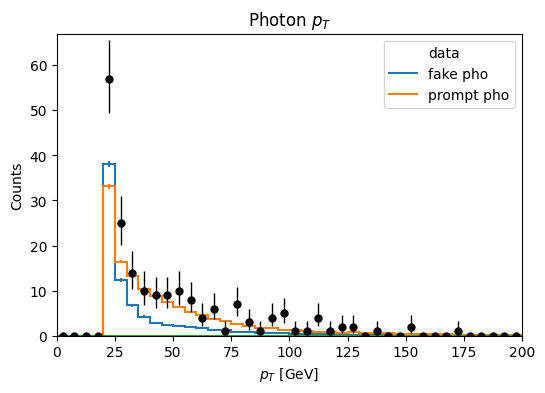

In [11]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_pt_hist'].sum("dataset"),overlay="flav",stack=False,legend_opts=data_legopts)
hist.plot1d(outputData['photon_pt_hist'].sum("dataset"),stack=False,error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,67); plt.title('Photon $p_T$'); plt.show()

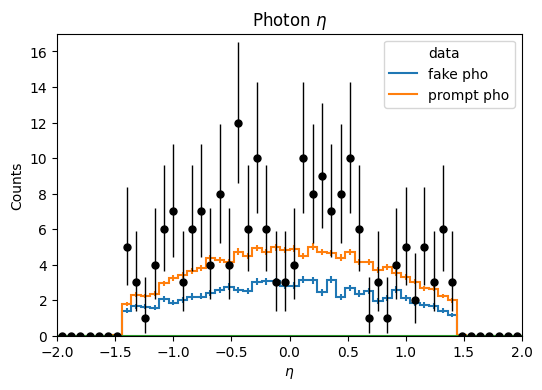

In [12]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_eta_hist'].sum("dataset"),overlay="flav",stack=False,legend_opts=data_legopts)
hist.plot1d(outputData['photon_eta_hist'].sum("dataset"),legend_opts=data_legopts,stack=False,error_opts=data_err_opts)
plt.ylim(0,17); plt.title('Photon $\eta$'); plt.show()

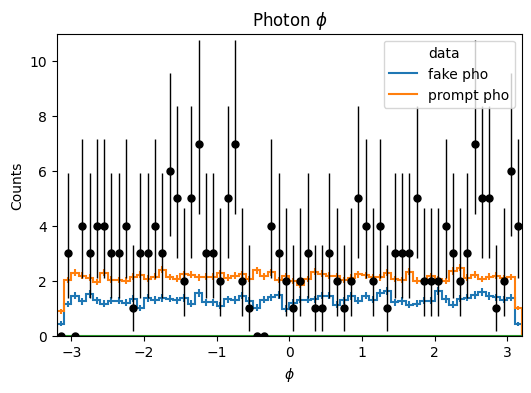

In [13]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_phi_hist'].sum("dataset"),overlay="flav",stack=False,legend_opts=data_legopts)
hist.plot1d(outputData['photon_phi_hist'].sum("dataset"),stack=False,error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,11); plt.title('Photon $\phi$'); plt.show()

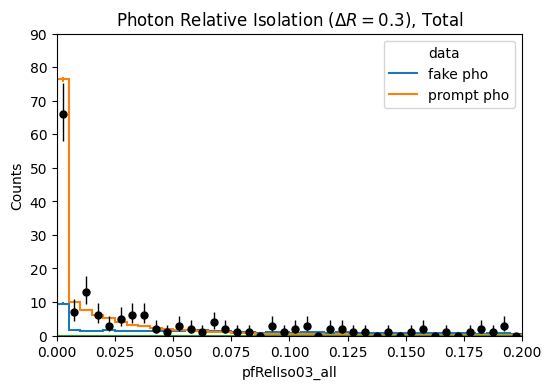

In [14]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_reliso_all_hist'].sum("dataset"),overlay="flav",stack=False,legend_opts=data_legopts)
hist.plot1d(outputData['photon_reliso_all_hist'].sum("dataset"),stack=False,error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,90); plt.title('Photon Relative Isolation ($\Delta R = 0.3$), Total'); plt.show()

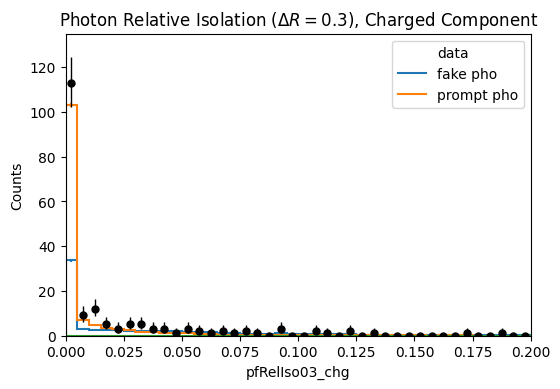

In [15]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_reliso_chg_hist'].sum("dataset"),overlay="flav",stack=False,legend_opts=data_legopts)
hist.plot1d(outputData['photon_reliso_chg_hist'].sum("dataset"),stack=False,error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,135); plt.title('Photon Relative Isolation ($\Delta R = 0.3$), Charged Component'); plt.show()

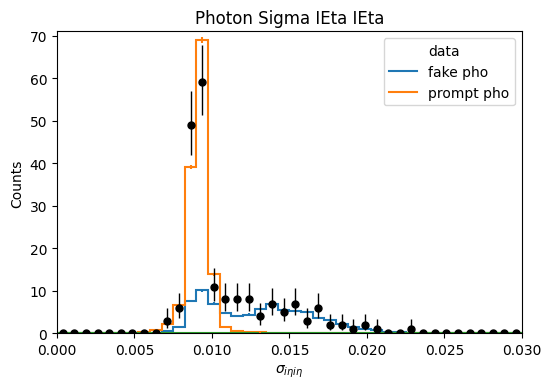

In [16]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_sieie_hist'].sum("dataset"),overlay="flav",stack=False)
hist.plot1d(outputData['photon_sieie_hist'].sum("dataset"),legend_opts=data_legopts,stack=False,error_opts=data_err_opts)
plt.ylim(0,71); plt.title('Photon Sigma IEta IEta'); plt.show()

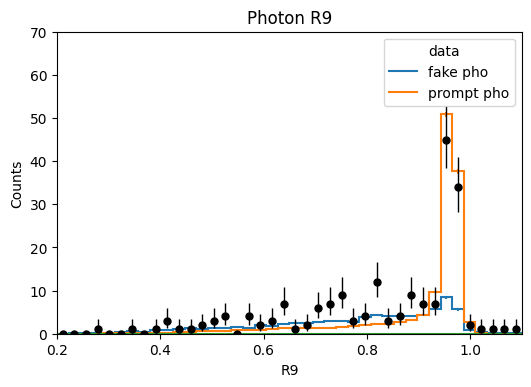

In [17]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_r9_hist'].sum("dataset"),overlay="flav",stack=False,legend_opts=data_legopts)
hist.plot1d(outputData['photon_r9_hist'].sum("dataset"),stack=False,error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,70); plt.title('Photon R9'); plt.show()

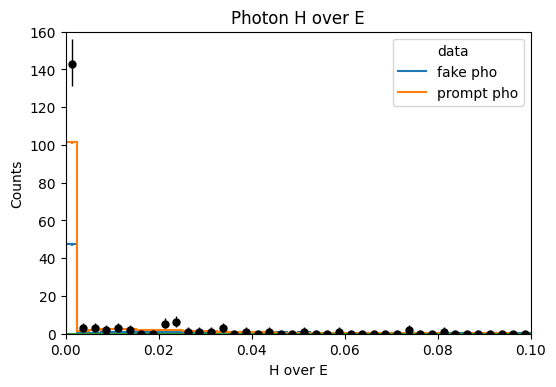

In [18]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_hoe_hist'].sum("dataset"),overlay="flav",stack=False,legend_opts=data_legopts)
hist.plot1d(outputData['photon_hoe_hist'].sum("dataset"),legend_opts=data_legopts,stack=False,error_opts=data_err_opts)
plt.ylim(0,160); plt.title('Photon H over E'); plt.show()

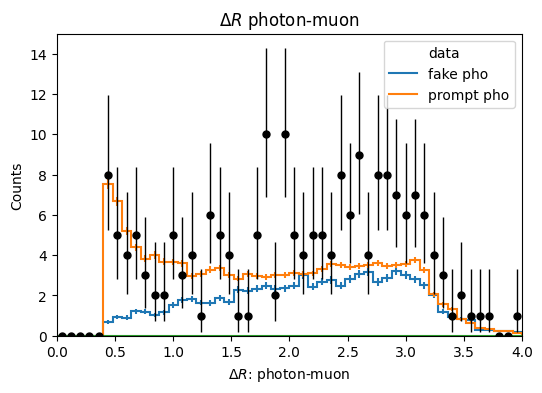

In [19]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['deltaR_photon_lepton_hist'].sum("dataset"),overlay="flav",stack=False,legend_opts=data_legopts)
hist.plot1d(outputData['deltaR_photon_lepton_hist'].sum("dataset"),legend_opts=data_legopts,stack=False,error_opts=data_err_opts)
plt.ylim(0,15); plt.title('$\Delta R$ photon-muon'); plt.show()

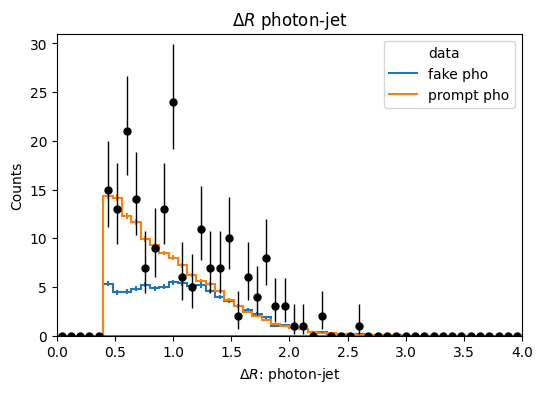

In [20]:
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['deltaR_photon_jet_hist'].sum("dataset"),overlay="flav",stack=False,legend_opts=data_legopts)
hist.plot1d(outputData['deltaR_photon_jet_hist'].sum("dataset"),stack=False,error_opts=data_err_opts,legend_opts=data_legopts)
plt.ylim(0,31); plt.title('$\Delta R$ photon-jet'); plt.show()

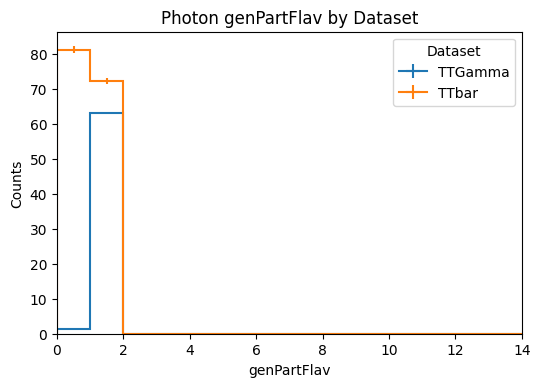

In [21]:
### label ###
plt.figure(figsize=(6,4),dpi=100)
hist.plot1d(outputMC['photon_genPartFlav_hist'],overlay='dataset',stack=False)
plt.title("Photon genPartFlav by Dataset")
plt.show()

In [22]:
outputMC['photon_genPartFlav_hist'].values() # few 13=prompt electrons (last bin)

{('TTbar',): array([8.11221749e+01, 7.21721342e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.72918365e-02]),
 ('TTGamma',): array([1.26674016e+00, 6.30861841e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.67630248e-03])}

## Preprocess data for training

In [23]:
df = pd.DataFrame({
    'photon_pt': np.array(outputMC['photon_pt'].value),
    'photon_eta': np.array(outputMC['photon_eta'].value),
    'photon_phi': np.array(outputMC['photon_phi'].value),
    'photon_hoe': np.array(outputMC['photon_hoe'].value),
    'photon_r9': np.array(outputMC['photon_r9'].value),
    'photon_sieie': np.array(outputMC['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputMC['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputMC['photon_pfRelIso03_chg'].value),
    
    'deltaR_photon_lepton': np.array(outputMC['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputMC['deltaR_photon_jet'].value),
    
    # MVA ID for later comparison. Removed before training.
    'photon_mvaID': np.array(outputMC['photon_mvaid'].value),
    
    'photon_genPartFlav': np.array(outputMC['photon_genPartFlav'].value), ## TARGET ##
})

df.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,photon_mvaID,photon_genPartFlav
count,175533.000000,175533.000000,175533.000000,175533.000000,175533.000000,175533.000000,175533.000000,175533.000000,175533.000000,175533.000000,175533.000000,175533.000000
mean,59.573669,0.007071,0.009872,0.009389,0.902115,0.009350,0.034985,0.011252,1.866255,0.983235,0.753927,0.946232
std,58.088821,0.728455,1.812061,0.029659,0.134649,0.001393,0.177741,0.044118,0.925957,0.442693,0.458601,0.270361
min,20.000051,-1.444092,-3.141602,0.000000,0.172485,0.000196,0.000000,0.000000,0.400002,0.400008,-0.999512,0.000000
25%,25.712778,-0.568115,-1.555664,0.000000,0.906738,0.008850,0.000000,0.000000,1.018647,0.619733,0.798828,1.000000
50%,39.792137,0.011684,0.004372,0.000000,0.955078,0.009186,0.002177,0.000000,1.887867,0.895582,0.944336,1.000000
75%,68.434349,0.582764,1.578125,0.005066,0.965820,0.009529,0.023749,0.004598,2.660657,1.258351,0.980957,1.000000
max,1116.671387,1.444092,3.141602,0.499023,14.820312,0.025925,18.950638,2.312275,4.776289,3.610590,0.998535,13.000000


In [24]:
df['photon_genPartFlav'].value_counts()

1     165770
0       9738
13        25
Name: photon_genPartFlav, dtype: int64

In [25]:
# relabel 13 (=prompt electrons) as 0
df['photon_genPartFlav'] = df['photon_genPartFlav'].replace(13,0)
df['photon_genPartFlav'].value_counts()

1    165770
0      9763
Name: photon_genPartFlav, dtype: int64

In [26]:
### shuffle & split into train, val, test datasets ###

X = df.drop(['photon_genPartFlav'],axis=1)
y = df['photon_genPartFlav']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [27]:
### remove MVA ID feature ###

test_mvaID = X_test['photon_mvaID']

X_train = X_train.drop(['photon_mvaID'],axis=1)
X_test = X_test.drop(['photon_mvaID'],axis=1)
X_val = X_val.drop(['photon_mvaID'],axis=1)

In [28]:
### Scale: mean=0, stdev=1 ###

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

## Build & train model

In [29]:
model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [30]:
callback = EarlyStopping(monitor='val_loss', patience=4)

history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=100, batch_size=512, callbacks=[callback])


Epoch 1/100
206/206 [==============================] - 1s 3ms/step - loss: 0.2637 - accuracy: 0.9045 - val_loss: 0.0976 - val_accuracy: 0.9730
Epoch 2/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9738 - val_loss: 0.0898 - val_accuracy: 0.9745
Epoch 3/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0867 - accuracy: 0.9747 - val_loss: 0.0869 - val_accuracy: 0.9749
Epoch 4/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0839 - accuracy: 0.9753 - val_loss: 0.0849 - val_accuracy: 0.9751
Epoch 5/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0819 - accuracy: 0.9758 - val_loss: 0.0837 - val_accuracy: 0.9755
Epoch 6/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0804 - accuracy: 0.9760 - val_loss: 0.0831 - val_accuracy: 0.9752
Epoch 7/100
206/206 [==============================] - 0s 2ms/step - loss: 0.0795 - accuracy: 0.9764 - val_loss: 0.0820 - val_accuracy: 0.9755

In [31]:
## save model:
path = !pwd
path

['/udrive/student/abraukman2020/PhotonClassification']

In [32]:
model.save(path[0])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /udrive/student/abraukman2020/PhotonClassification/assets


## Evaluate & Analyze Model
* Loss and accuracy
* ROC curve, AUC score
* Prediction (output) distribution
* Correlation matrix
* Run model on data


* Compare model predictions to MVA ID score
* Analyze incorrectly classified fake photons (false positive results)

In [33]:
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test loss: {round(loss,5)}\nTest accuracy: {round(accuracy,5)}')

Test loss: 0.07715
Test accuracy: 0.97687


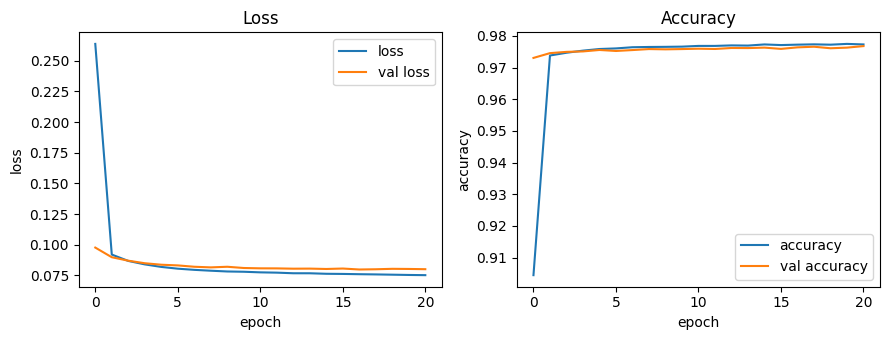

In [34]:
fig, axs = plt.subplots(1,2,figsize=(9,3.5),dpi=100)

axs[0].plot(history.history['loss'],label="loss")
axs[0].plot(history.history['val_loss'],label="val loss")
axs[1].plot(history.history['accuracy'],label="accuracy")
axs[1].plot(history.history['val_accuracy'],label="val accuracy")

axs[0].set_xlabel('epoch'); axs[0].set_ylabel('loss'); axs[0].set_title('Loss')
axs[1].set_xlabel('epoch'); axs[1].set_ylabel('accuracy'); axs[1].set_title('Accuracy')
axs[0].legend(); axs[1].legend()

plt.tight_layout()
plt.show()

### ROC Curve

In [35]:
y_pred = model.predict(X_test_scaled)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
area_under_curve = auc(fpr, tpr)

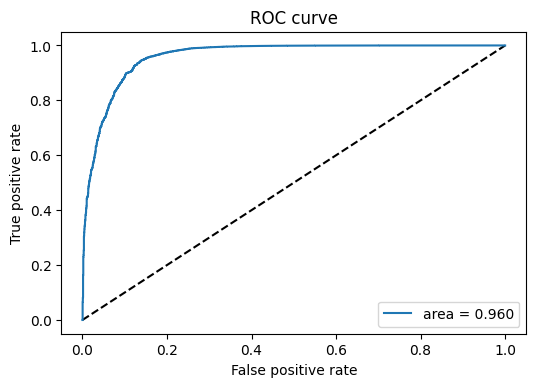

In [36]:
plt.figure(figsize=(6,4),dpi=100)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(area_under_curve))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Prediction Distribution

In [37]:
predTrue  = y_pred[y_test==True]
predFalse = y_pred[y_test==False]

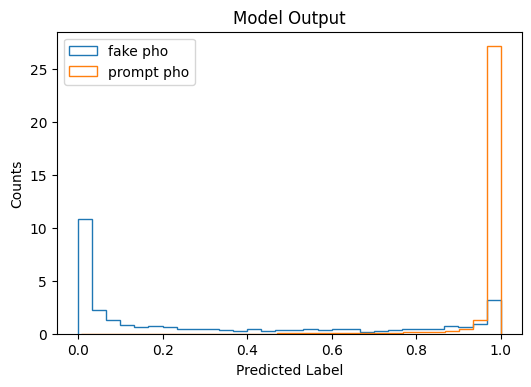

In [38]:
plt.figure(figsize=(6,4),dpi=100)

plt.hist(predFalse,bins=30,density=True,label='fake pho',histtype='step')
plt.hist(predTrue,bins=30,density=True,label='prompt pho',histtype='step')

plt.xlabel('Predicted Label')
plt.ylabel('Counts')
plt.title('Model Output')
plt.legend(loc='upper left')
plt.show()

### Correlation Matrix

In [39]:
X_test['prediction'] = y_pred
X_test.corr()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,prediction
photon_pt,1.000000,-0.002538,0.002668,-0.083765,0.136182,-0.067565,-0.079733,-0.090810,0.150891,0.219224,0.102016
photon_eta,-0.002538,1.000000,-0.008060,0.000307,0.012591,0.011050,0.012424,0.007027,-0.010673,-0.010961,0.002312
photon_phi,0.002668,-0.008060,1.000000,0.004805,0.002962,0.004889,0.003063,0.002179,0.012233,0.012971,-0.008162
photon_hoe,-0.083765,0.000307,0.004805,1.000000,-0.116555,0.300710,0.207128,0.199347,0.022728,-0.020916,-0.388922
photon_r9,0.136182,0.012591,0.002962,-0.116555,1.000000,-0.017741,0.015980,-0.082168,-0.000631,0.014278,0.275394
photon_sieie,-0.067565,0.011050,0.004889,0.300710,-0.017741,1.000000,0.359574,0.258337,0.045336,0.027039,-0.769799
photon_pfRelIso03_all,-0.079733,0.012424,0.003063,0.207128,0.015980,0.359574,1.000000,0.477301,0.051930,-0.028032,-0.511628
photon_pfRelIso03_chg,-0.090810,0.007027,0.002179,0.199347,-0.082168,0.258337,0.477301,1.000000,0.054082,-0.056181,-0.405228
deltaR_photon_lepton,0.150891,-0.010673,0.012233,0.022728,-0.000631,0.045336,0.051930,0.054082,1.000000,0.323574,-0.104892
deltaR_photon_jet,0.219224,-0.010961,0.012971,-0.020916,0.014278,0.027039,-0.028032,-0.056181,0.323574,1.000000,-0.062942


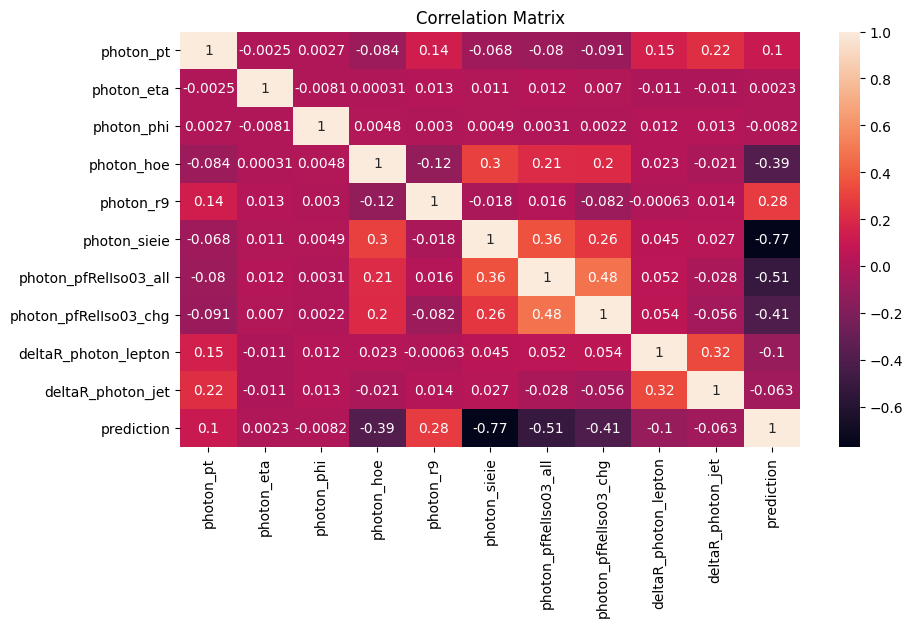

In [40]:
plt.figure(figsize=(10,5.5),dpi=100)
sns.heatmap(X_test.corr(method='pearson'),annot=True)
plt.title('Correlation Matrix')
plt.show()

### Run Model on Data

In [41]:
X_data = pd.DataFrame({
    'photon_pt': np.array(outputData['photon_pt'].value),
    'photon_eta': np.array(outputData['photon_eta'].value),
    'photon_phi': np.array(outputData['photon_phi'].value),
    'photon_hoe': np.array(outputData['photon_hoe'].value),
    'photon_r9': np.array(outputData['photon_r9'].value),
    'photon_sieie': np.array(outputData['photon_sieie'].value),
    'photon_pfRelIso03_all': np.array(outputData['photon_pfRelIso03_all'].value),
    'photon_pfRelIso03_chg': np.array(outputData['photon_pfRelIso03_chg'].value),
    
    'deltaR_photon_lepton': np.array(outputData['deltaR_photon_lepton'].value),
    'deltaR_photon_jet': np.array(outputData['deltaR_photon_jet'].value),
})

X_data.describe()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,52.356056,-0.044832,0.072516,0.017655,0.851021,0.010832,0.165943,0.041700,2.082007,1.039004
std,44.367550,0.745467,1.903635,0.049518,0.285727,0.003040,0.449675,0.123595,0.907346,0.467483
min,20.195528,-1.414795,-3.038086,0.000000,0.287842,0.006866,0.000000,0.000000,0.405593,0.407462
25%,23.336668,-0.622070,-1.538574,0.000000,0.737793,0.008942,0.000000,0.000000,1.362517,0.635844
50%,35.041878,-0.029804,-0.127930,0.000000,0.911133,0.009369,0.025838,0.000153,2.180455,0.971324
75%,62.303696,0.484802,1.781738,0.003136,0.962402,0.012047,0.141506,0.028607,2.800998,1.358855
max,297.663422,1.439697,3.133789,0.314453,4.050781,0.023056,4.619414,1.231754,4.449972,2.619408


In [42]:
scaler = StandardScaler()
X_data_scaled = scaler.fit_transform(X_data)

In [43]:
y_pred_data = model.predict(X_data_scaled)

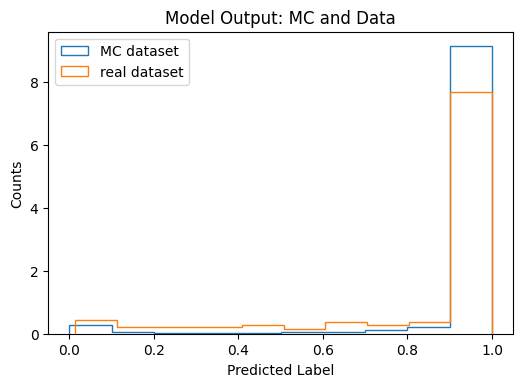

In [44]:
plt.figure(figsize=(6,4),dpi=100)

plt.hist(y_pred,density=True,label="MC dataset",histtype='step')
plt.hist(y_pred_data,density=True,label="real dataset",histtype='step')

plt.xlabel("Predicted Label")
plt.ylabel("Counts")
plt.title("Model Output: MC and Data")
plt.legend(loc='upper left')

#plt.yscale('log')
plt.show()

### Compare to MVA ID

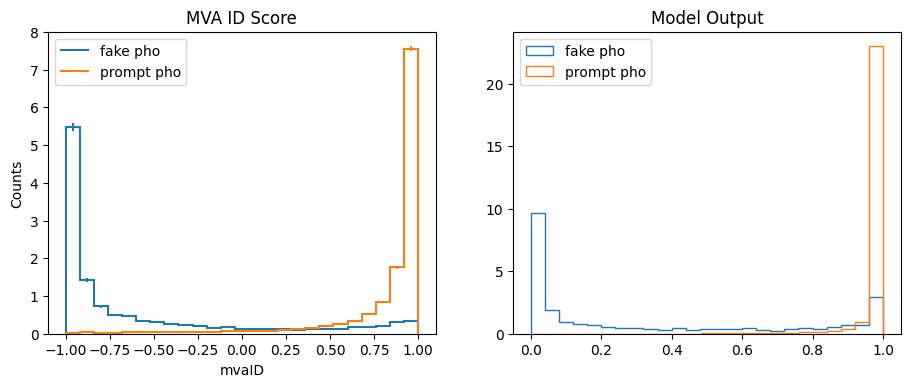

In [45]:
fig, axs = plt.subplots(1,2,figsize=(11,4),dpi=100)

MC_legend_opts = {'loc':'upper left', 'labels': ['fake pho','prompt pho']}
hist.plot1d(outputMC['photon_mvaid_hist'].sum("dataset"),overlay="flav",stack=False,density=True,ax=axs[0],legend_opts=MC_legend_opts)
axs[0].set_xlim(-1.1,1.1)

axs[1].hist(predFalse,bins=25,density=True,label='fake pho',histtype='step')
axs[1].hist(predTrue,bins=25,density=True,label='prompt pho',histtype='step')
axs[1].legend(loc="upper left")

axs[0].set_title('MVA ID Score')
axs[1].set_title('Model Output')
plt.show()

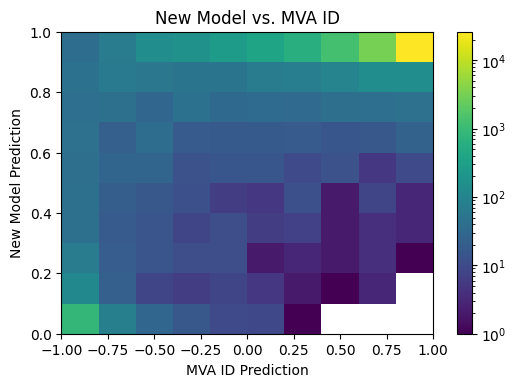

In [46]:
## 2D histograms: new model vs. MVA ID ##
plt.figure(figsize=(6,4),dpi=100)

plt.hist2d(test_mvaID, y_pred.reshape(y_pred.shape[0]),norm=colors.LogNorm())

plt.xlabel('MVA ID Prediction'); plt.xlim(-1,1)
plt.ylabel('New Model Prediction'); plt.ylim(0,1)
plt.title('New Model vs. MVA ID')
plt.colorbar()
plt.show()


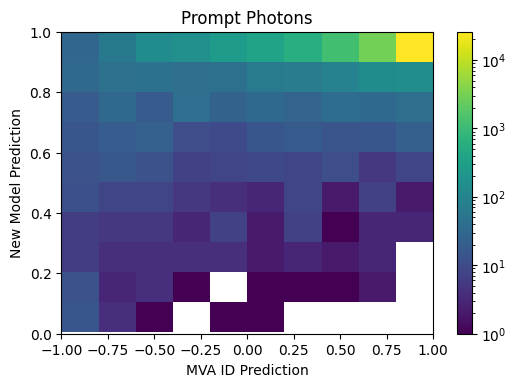

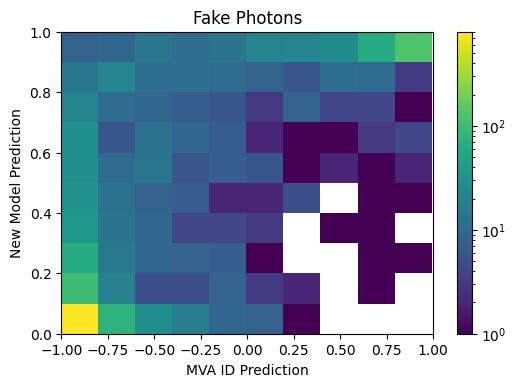

In [47]:
# separate above plot into fake photons and prompt photons

mvaTrue = test_mvaID[y_test==1]
mvaFalse = test_mvaID[y_test==0]

plt.figure(figsize=(6,4),dpi=100)
plt.hist2d(mvaTrue,predTrue.reshape(predTrue.shape[0]),norm=colors.LogNorm())
plt.xlabel('MVA ID Prediction'); plt.ylabel('New Model Prediction')
plt.xlim(-1,1); plt.ylim(0,1)
plt.title('Prompt Photons')
plt.colorbar()
plt.show()

plt.figure(figsize=(6,4),dpi=100)
plt.hist2d(mvaFalse,predFalse.reshape(predFalse.shape[0]),norm=colors.LogNorm())
plt.xlabel('MVA ID Prediction'); plt.ylabel('New Model Prediction')
plt.xlim(-1,1); plt.ylim(0,1)
plt.title('Fake Photons')
plt.colorbar()
plt.show()


In [48]:
### analyze events where model output = 1, MVA ID = -1 ###

X_test['mvaID'] = test_mvaID

modPos_mvaPos = X_test[(X_test['prediction']>0.5) & (X_test['mvaID']>0)]
modNeg_mvaNeg = X_test[(X_test['prediction']<0.5) & (X_test['mvaID']<0)]
modPos_mvaNeg = X_test[(X_test['prediction']>0.5) & (X_test['mvaID']<0)]
modPos_mvaNeg.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,prediction,mvaID
160126,23.384562,1.361084,2.869141,0.044922,0.441406,0.008736,0.260578,0.219365,0.588980,0.408409,0.759858,-0.861816
159538,61.006531,-0.196014,-1.557129,0.012512,0.704590,0.008774,0.051263,0.051263,2.283052,0.472363,0.921402,-0.640137
6936,82.030388,-0.123428,-1.622314,0.000000,0.963379,0.009338,0.204190,0.020233,1.656039,0.696746,0.773896,-0.251953
23464,119.714760,0.519653,0.342712,0.000000,0.950195,0.010170,0.037802,0.029485,1.664883,0.640206,0.922865,-0.901367
51391,69.289864,0.822876,-2.615723,0.007904,0.932617,0.013023,0.022650,0.015070,2.202409,0.749534,0.632143,-0.599609


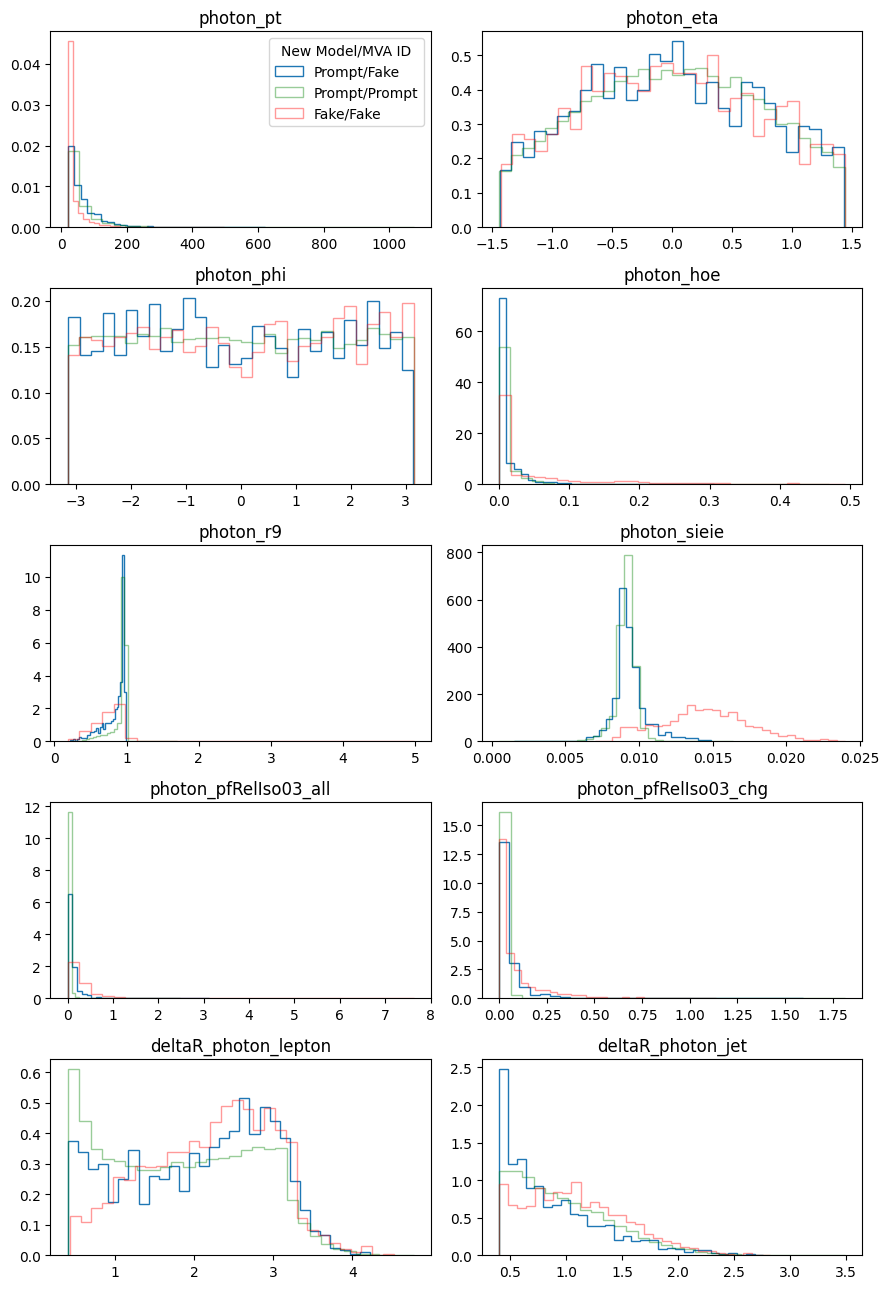

In [60]:
# compare features:
fig, axs = plt.subplots(5,2,figsize=(9,13),dpi=100)

feat = 0
for row in range(5):
    for col in range(2):
        axs[row,col].hist(modPos_mvaNeg[modPos_mvaNeg.keys()[feat]],bins=30,histtype="step",density=True,label="Prompt/Fake")
        axs[row,col].hist(modPos_mvaPos[modPos_mvaNeg.keys()[feat]],bins=30,histtype="step",alpha=0.4,density=True,color="green",label="Prompt/Prompt")
        axs[row,col].hist(modNeg_mvaNeg[modPos_mvaNeg.keys()[feat]],bins=30,histtype="step",alpha=0.4,density=True,color="red",label="Fake/Fake")
        axs[row,col].set_title(modPos_mvaNeg.keys()[feat])
        feat = feat+1

axs[0,0].legend(loc="best",title="New Model/MVA ID")
fig.tight_layout()
plt.show()

In [50]:
## ROC curve for MVA ID ##

fprMVA, tprMVA, threshMVA = roc_curve(y_test,test_mvaID)
aucMVA = auc(fprMVA,tprMVA)

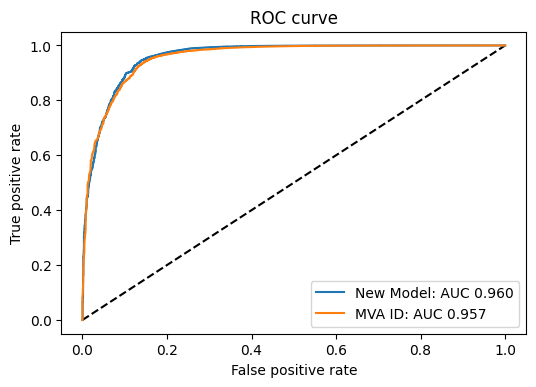

In [51]:
plt.figure(figsize=(6,4),dpi=100)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='New Model: AUC {:.3f}'.format(area_under_curve))
plt.plot(fprMVA, tprMVA, label='MVA ID: AUC {:.3f}'.format(aucMVA))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Analyze Incorrectly-Classified Fake Photons

In [52]:
X_test['target'] = y_test
X_test.head()

,photon_pt,photon_eta,photon_phi,photon_hoe,photon_r9,photon_sieie,photon_pfRelIso03_all,photon_pfRelIso03_chg,deltaR_photon_lepton,deltaR_photon_jet,prediction,mvaID,target
8516,30.463993,0.880859,-1.915527,0.0,0.949219,0.010048,0.018221,0.007790,0.777518,0.776676,0.993477,0.871094,1
102009,94.219284,-0.369934,1.111084,0.0,0.953125,0.010170,0.005113,0.000000,1.756086,1.721098,0.996342,0.940430,1
150294,35.572186,0.451965,-2.906738,0.0,0.677734,0.008987,0.014813,0.000000,1.577970,1.222363,0.976966,0.904297,1
151346,28.033655,0.118546,-1.927979,0.0,0.973145,0.009613,0.000391,0.000391,3.076556,0.754890,0.998186,0.988770,1
86352,36.612545,0.598633,0.985962,0.0,0.967285,0.009254,0.000000,0.000000,1.333299,1.288000,0.998249,0.987793,1


In [53]:
# incorrectly-classified fake photons:
# target = 0, prediction > 0.5

falseNeg = X_test[(X_test['target'] == 1) & (X_test['prediction'] < 0.5)]
truePos  = X_test[(X_test['target'] == 1) & (X_test['prediction'] > 0.5)]
trueNeg  = X_test[(X_test['target'] == 0) & (X_test['prediction'] < 0.5)]
falsePos = X_test[(X_test['target'] == 0) & (X_test['prediction'] > 0.5)]

In [54]:
# confusion matrix
con_mat = np.array([len(trueNeg),len(falsePos),len(falseNeg),len(truePos)])
con_mat_names = np.array(['True Neg:','False Pos:','False Neg:','True Pos:'])
con_mat_perc = ((con_mat/np.sum(con_mat))*100).round(2)

con_mat.reshape(2,2)

array([[ 1330,   634],
       [  178, 32965]])

In [55]:
labels = [f"{v1}\n{v2}\n({v3}%)" for v1,v2,v3 in zip(con_mat_names,con_mat,con_mat_perc)]
labels = np.asarray(labels).reshape(2,2)

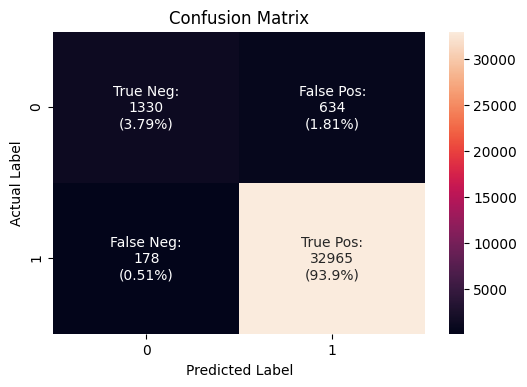

In [61]:
plt.figure(figsize=(6,4),dpi=100)
sns.heatmap(con_mat.reshape(2,2),annot=labels,fmt='')
plt.xlabel('Predicted Label'); plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

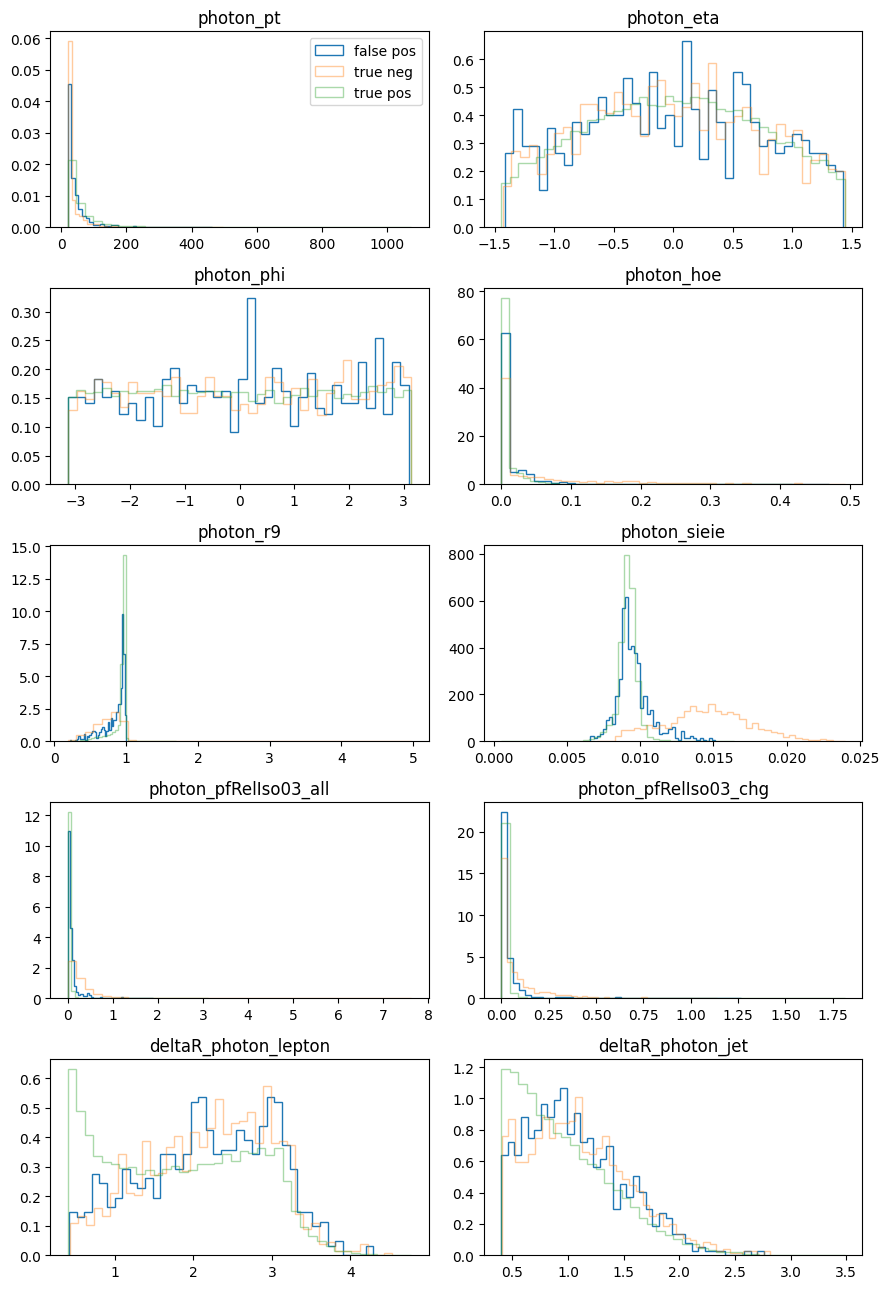

In [57]:
### compare features ###

fig, axs = plt.subplots(5,2,figsize=(9,13),dpi=100)

feat = 0
for row in range(5):
    for col in range(2):
        axs[row,col].hist(falsePos[falsePos.keys()[feat]],bins=40,histtype="step",density=True,label="false pos")
        axs[row,col].hist(trueNeg[falsePos.keys()[feat]],bins=40,histtype="step",alpha=0.4,density=True,label="true neg")
        axs[row,col].hist(truePos[falsePos.keys()[feat]],bins=40,histtype="step",alpha=0.4,density=True,label="true pos")
        axs[0,0].legend(loc="best")
        axs[row,col].set_title(falsePos.keys()[feat])
        feat = feat+1

fig.tight_layout()
plt.show()

# falsePos = incorrectly classified fake photons
# trueNeg = correctly classified fake photons (expected to look different from falsePos)
# truePos = correctly classified prompt photons (expected to look like falsePos)

### Plot ROC curve manually

In [58]:
FPR = []
TPR = []

thresholds = np.linspace(0,1,num=201)

# number of positive (P) and negative (N) samples
P = X_test.target.sum()
N = len(X_test.target) - P

# determine number of true pos & false pos samples for each threshold
for thresh in thresholds:
    FP = 0
    TP = 0
    
    pos = X_test[X_test.prediction>=thresh]
    
    TP = pos.target.sum()
    FP = len(pos.target) - TP
    
    FPR.append(FP/N)
    TPR.append(TP/P)

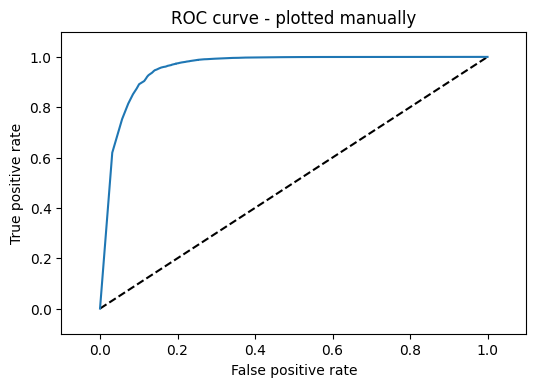

In [59]:
plt.figure(figsize=(6,4),dpi=100)

plt.plot([0,1], [0,1], 'k--')
plt.plot(FPR, TPR)

plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - plotted manually')
plt.show()